## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

# Task 1: Create a classifier

The first attempt for this task was based on a multi-label strategy. I have kept some of the code for that in the notebook. However, there were several issues with that approach. The biggest one being the system not being able to form a very good decision boundary as a result everything started getting classified into a general category.

The current approach is based on a conventional multiclass classifier.

In [279]:
# importing the required modules
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import gradients, mean

from sklearn.model_selection import train_test_split

In [3]:
# find path for the data
data_path = 'Data'

### Process the Training Data

In [4]:
# read the training labels
train_labels = pd.read_csv(os.path.join(data_path, 'train/train.csv'))
train_labels.set_index('filename', inplace=True)
train_labels.head()

,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
filename,,,,,,,
c24a1b14d253.jpg,0,0,0,0,0,1,0
9ee905a41651.jpg,0,0,0,0,0,1,0
3f58d128caf6.jpg,0,0,1,0,0,0,0
4ce6599e7b20.jpg,1,0,0,0,1,0,0
0def470360e4.jpg,1,0,0,0,1,0,0


In [5]:
# check distribution of different disese and also overlap between different disease
for label in train_labels.columns[1:]:
    print(label)
    print(train_labels[label].value_counts(), '\n')

diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64 

glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64 

macular edema
0    2919
1     516
Name: macular edema, dtype: int64 

macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64 

retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64 

normal
0    2910
1     525
Name: normal, dtype: int64 



### Create Data Pipelines

In [9]:
# separating files into 4 categories

## create separate dataset from existing training file
original_folder = os.path.join(data_path, 'train/train')
new_folder = os.path.join(data_path, 'separated_pics_train')

# index = 1
dbr_folder = os.path.join(new_folder, 'diabetic retinopathy')

# index = 2
glc_folder = os.path.join(new_folder, 'glaucoma')

# index else
other_folder = os.path.join(new_folder, 'other')

# index = 6
normal_folder = os.path.join(new_folder, 'normal')

for i in range(len(train_labels)):
    max_val = train_labels.iloc[i].max()
    indices = [i for i, j in enumerate(train_labels.iloc[i]) if j == max_val]

    '''commands to move files to designated folders'''
    if 1 in indices:
        shutil.copy(os.path.join(original_folder, train_labels.index[i]), 
                    os.path.join(dbr_folder, train_labels.index[i]))
    
    elif 2 in indices:
        shutil.copy(os.path.join(original_folder, train_labels.index[i]), 
                    os.path.join(glc_folder, train_labels.index[i]))
        
    elif 6 in indices:
        shutil.copy(os.path.join(original_folder, train_labels.index[i]), 
                    os.path.join(normal_folder, train_labels.index[i]))
        
    else:
        shutil.copy(os.path.join(original_folder, train_labels.index[i]), 
                    os.path.join(other_folder, train_labels.index[i]))

In [217]:
# define image size and channels
IMAGE_SIZE = 224
CHANNELS = 3

BATCH_SIZE = 64

In [218]:
# training image dir
train_img_dir = os.path.join(data_path, 'separated_pics_train')

# testing image dir
test_img_dir = 'Data/test'

In [219]:
# preprocessing function to highlight the green channel
def green_channel(img):
    img_out = img[:,:,1]
    return img_out

In [304]:
# increasing contrast
def contrast(img_np):
    return(tf.image.adjust_contrast(img_np, 4))

In [305]:
train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(-0.5,0.5),
    fill_mode='constant',
    data_format="channels_last",
    #preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    preprocessing_function=contrast,
    validation_split = 0.3,
    rescale=1.0/255.0
)

In [306]:
# create training data
train_gen = train_datagen.flow_from_directory(
    directory=train_img_dir,
    shuffle=True, 
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 1827 images belonging to 4 classes.


In [307]:
# create training data
val_gen = train_datagen.flow_from_directory(
    directory=train_img_dir,
    shuffle=True, 
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 780 images belonging to 4 classes.


### Creating callback for saving models and stopping training if certain accuracy is reached.

In [16]:
# define callback to stop training if a certain accuracy is achieved
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(seld, epoch, logs={}):
        if (logs.get('accuracy')>0.95):
            print('\nReached 95% accuracy so cancelling training')
            self.model.stop_training = True
    
stop_train = mycallback()

In [271]:
# callback for saving checkpoints during training
accuracy_callback = tf.keras.callbacks.ModelCheckpoint(
    'models/acc_ckpts',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
)

In [164]:
# function for lr decay
def scheduler(epoch, lr):
    if epoch % 20 != 0:
        return lr
    else:
        return lr / 10

In [166]:
# learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Download application from the tf.keras.application

In [308]:
# importing ResNet50 from tensorflow applications
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet')

In [309]:
base_model.trainable = True
#base_model.summary()

In [310]:
# select a layer to start optimizing from, 
# here we will train only the later half of the model
train_layer = base_model.get_layer('conv4_block4_1_conv')

# get train_layer index
layer_index = base_model.layers.index(train_layer)

In [311]:
# make layers before the training layer non trainable
for layer in base_model.layers[:layer_index]:
    layer.trainable = False

Skipping the final activation layer and just getting the logits as these will be used for the final part of the assignment

In [312]:
# define model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 2052      
Total params: 24,638,852
Trainable params: 19,383,300
Non-trainable params: 5,255,552
_________________________________________________________________


In [313]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics='accuracy')

In [314]:
# train model
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.samples // BATCH_SIZE,
                    epochs= 100,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // BATCH_SIZE,
                    callbacks=[accuracy_callback])
                    #callbacks=[stop_train, accuracy_callback, lr_decay])

Epoch 1/100
28/28 [==============================] - 53s 2s/step - loss: 9.4444 - accuracy: 0.2150 - val_loss: 7.8282 - val_accuracy: 0.2839
Epoch 2/100
28/28 [==============================] - 51s 2s/step - loss: 8.2100 - accuracy: 0.2791 - val_loss: 8.2060 - val_accuracy: 0.2878
Epoch 3/100
28/28 [==============================] - 50s 2s/step - loss: 8.1642 - accuracy: 0.2864 - val_loss: 8.3529 - val_accuracy: 0.2839
Epoch 4/100
28/28 [==============================] - 49s 2s/step - loss: 8.2373 - accuracy: 0.2887 - val_loss: 8.2479 - val_accuracy: 0.2839
Epoch 5/100
28/28 [==============================] - 47s 2s/step - loss: 8.1186 - accuracy: 0.2864 - val_loss: 8.2060 - val_accuracy: 0.2878
Epoch 6/100
28/28 [==============================] - 48s 2s/step - loss: 7.9996 - accuracy: 0.2859 - val_loss: 8.2479 - val_accuracy: 0.2878
Epoch 7/100
28/28 [==============================] - 49s 2s/step - loss: 8.2739 - accuracy: 0.2853 - val_loss: 8.2479 - val_accuracy: 0.2865
Epoch 8/100
2

In [302]:
model.save('models/resnet50_v2.h5')
model.save_weights('models/resnet50_weights_v2')

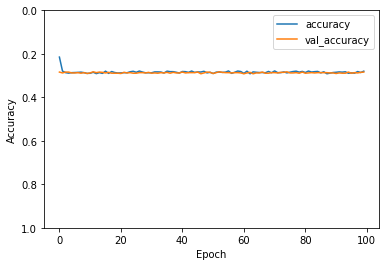

In [315]:
# plottig history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1, 0])
plt.legend(loc='upper right')
plt.show()

## Creating Saliency Maps

The problem with creating saliency maps with the custom architecture is that the preloaded model appears as a functional layer. The sublayers in this functional model cannot be called directly. As a result the model gives a "Graph Disconnected" error.

To workaround this problem a new model is defined without any weights. Weights from pre-trained model are then loaded in this new model and the last conv layer from this model is passed on to the saliency map input and output.

In [63]:
# use this cell if loading a pre-trained model
model_pretrained = tf.keras.models.load_model('models/effnet_v1.h5')
model_pretrained.trainable = False
model_pretrained.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 8, 8, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 8196      
Total params: 28,521,723
Trainable params: 0
Non-trainable params: 28,521,723
_________________________________________________________________


In [64]:
# define the classifier layer that will be used to calculate the output
classifier_layers = ['global_average_pooling2d_7', 'dense_6']

In [ ]:
# define new model
base_model = tf.keras.applications.EfficientNetB5(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights=None
)
base_model.trainable = False
base_model.summary()

In [ ]:
# load weights in the newly created model
base_model.load_weights('models/effnet_weights')

In [92]:
# get list of examples to create the heatmaps
img_path_list = os.listdir('category _examples')

In [69]:
# function to load images to numpy array and normalize
def img_to_np(img_path):
    # open image using PIL
    img_temp = Image.open(img_path)
    img_temp = img_temp.resize((IMAGE_SIZE,IMAGE_SIZE), resample=1)

    # convert to np array
    img_temp = np.array(img_temp).astype(np.float32)
    img_temp = img_temp/255.0
    
    return img_temp

In [70]:
# function to cover image with heat map
def cover_img(img_path, heatmap):
    # Use cv2 to load the original image
    img_original = cv2.imread(img_path)

    # set the intensity map at 0.5
    INTENSITY = 0.5

    # Resize the heatmap to have the same size as the original image
    heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    # Convert the heatmap to RGB
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # We apply the heatmap to the original image
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # processed image
    img_new = heatmap_resized * INTENSITY + img_original

    return img_new

### Get Gradient on Images
Finally test the functions on all images. We will also save all the bounding boxes with the file names in a dict.

In [71]:
# import needed modules
from tensorflow import GradientTape

In [ ]:
base_model.summary()

In [80]:
# last conv layer of the base model
last_conv_layer_1 = 'top_conv'

In [81]:
def make_gradcam_heatmap(
    img_array, model, pre_trained_model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = pre_trained_model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

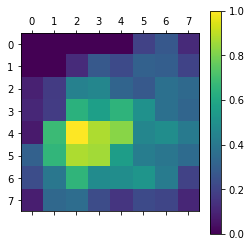

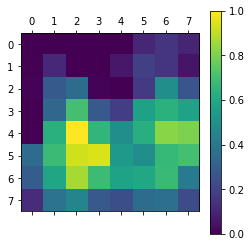

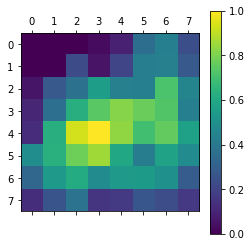

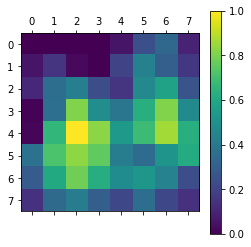

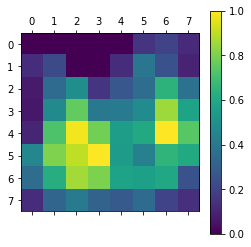

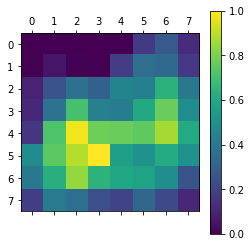

In [106]:
for img in img_path_list:
    img_path = os.path.join('category _examples',img)
    img_temp = img_to_np(img_path)
    img_temp = np.expand_dims(img_temp, axis=0)
    
    htmp = make_gradcam_heatmap(img_temp, base_model, model_pretrained, last_conv_layer_1, classifier_layers)
    # the reshape value will very if a different model is used since the shape 
    # depends on the output of the final conv layer, so make changes accordingly
    heatmap = htmp.reshape((8, 8))
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()
    
    # save image with heatmap cover
    #plt.imshow(cover_img(img_path, htmp), cmap='gray', interpolation='bicubic')
    cv2.imwrite(os.path.join('img_heatmap', img), cover_img(img_path, htmp))

## Overlain images
<img src="img_heatmap/dbr1.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/dbr2.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/glc1.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/glc2.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/normal1.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/normal2.jpg" alt="diabetic retinopathy" width="200"/>

# Label Propogation

### Setting up Label Propogation

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

In [326]:
# load trained model
model_pretrained = tf.keras.models.load_model('models/resnet50_v1.h5')
model_pretrained.trainable = False

In [327]:
model_pretrained.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 2052      
Total params: 24,638,852
Trainable params: 0
Non-trainable params: 24,638,852
_________________________________________________________________


In [328]:
last_dense_layer = 'dense_38'

In [329]:
# setup to get the output from the last dense layer
last_layer = model_pretrained.get_layer(last_dense_layer)
last_conv_layer_model = tf.keras.Model(model_pretrained.inputs, last_layer.output)

In [330]:
# creating a train array for passing to knn
pred_train = np.array([ 'name', 'p1', 'p2', 'p3', 'p4', 'labels', 'label_num'])
pred_train = np.expand_dims(pred_train, axis=0)
pred_train.shape

(1, 7)

In [331]:
train_original_dir = 'Data/train/train'

In [332]:
# iterating over the image folder to collect predictions, names and labels
for pic in os.listdir(train_original_dir):
    # get image array
    im_temp = img_to_np(os.path.join(train_original_dir, pic))
    im_temp = np.expand_dims(im_temp, axis=0)

    pred_temp = []

    # get image label
    max_val = 1
    labels = [i for i in train_labels.loc[pic].values]

    if labels[1] == 1:
        pred_temp.append(pic)
        for j in last_conv_layer_model.predict(im_temp)[0]:
            pred_temp.append(j)
        pred_temp.append('diabetic retinopathy')
        pred_temp.append(1)
    elif labels[2] == 1:
        pred_temp.append(pic)
        for j in last_conv_layer_model.predict(im_temp)[0]:
            pred_temp.append(j)
        pred_temp.append('glaucoma')
        pred_temp.append(2)
    elif labels[6] == 1:
        pred_temp.append(pic)
        for j in last_conv_layer_model.predict(im_temp)[0]:
            pred_temp.append(j)
        pred_temp.append('normal')
        pred_temp.append(3)
    else:
        pred_temp.append(pic)
        for j in last_conv_layer_model.predict(im_temp)[0]:
            pred_temp.append(j)
        pred_temp.append('other')
        pred_temp.append(4)

    pred_train = np.append(pred_train, np.expand_dims(np.array(pred_temp), axis=0), axis=0)

In [333]:
# extract specific columns from np array
# use X = data[:, [1, 9]]
X_train = pred_train[1:,[1, 2, 3, 4]]

In [334]:
# extract targets
y_train = pred_train[1:, [6]]

In [335]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [336]:
# create a label propagation model
prop = KNN(n_neighbors=4)

In [337]:
# fit the model
prop.fit(X_train.astype(np.float32), y_train.ravel())

KNeighborsClassifier(n_neighbors=4)

In [338]:
# predict labels for the test folder
# creating a test array for passing to knn model
pred_test = np.array(['name', 'labels', 'label_num'])
pred_test = np.expand_dims(pred_test, axis=0)
pred_test.shape

(1, 3)

In [339]:
# create labels for the test images
# iterating over the image folder to collect predictions, names and labels
for pic in os.listdir(test_img_dir):
    # get image array
    im_temp = img_to_np(os.path.join(test_img_dir, pic))
    im_temp = np.expand_dims(im_temp, axis=0)

    pred_temp = []

    # get image predited labels
    label_predicted = prop.predict(np.expand_dims(
        last_conv_layer_model.predict(im_temp)[0], axis=0))
  
    # append labels to the new array
    if int(label_predicted[0]) == 1:
        pred_temp.append(pic)
        pred_temp.append('diabetic retinopathy')
        pred_temp.append(1)

    elif int(label_predicted[0]) == 2:
        pred_temp.append(pic)
        pred_temp.append('galucoma')
        pred_temp.append(2)

    elif int(label_predicted[0]) == 3:
        pred_temp.append(pic)
        pred_temp.append('normal')
        pred_temp.append(3)

    else:
        pred_temp.append(pic)
        pred_temp.append('other')
        pred_temp.append(4)

    pred_test = np.append(pred_test, np.expand_dims(np.array(pred_temp), axis=0), axis=0)

### Append the test data to train data

In [340]:
pred_test_ = pred_test[1:]
pred_test_.shape

(350, 3)

In [341]:
# create new folders with images
new_image_dir = 'Data/separated_pics_aug'

for row in pred_test_:
    file_name = row[0]
    label_num = row[2]

    if label_num == 1:
        shutil.copy(os.path.join(test_img_dir, file_name), 
                    os.path.join(new_image_dir, 'diabetic retinopathy/'+file_name))
  
    elif label_num == 2:
        shutil.copy(os.path.join(test_img_dir, file_name), 
                    os.path.join(new_image_dir, 'glaucoma/'+file_name))
    
    elif label_num == 3:
        shutil.copy(os.path.join(test_img_dir, file_name), 
                    os.path.join(new_image_dir, 'normal/'+file_name))
  
    else:
        shutil.copy(os.path.join(test_img_dir, file_name), 
                    os.path.join(new_image_dir, 'other/'+file_name))

## Train on Concatenated Data

In [342]:
# check if the data has been added
print(len(os.listdir('Data/separated_pics_train/diabetic retinopathy')))
print(len(os.listdir('Data/separated_pics_aug/diabetic retinopathy')))
print(len(os.listdir('Data/separated_pics_train/glaucoma')))
print(len(os.listdir('Data/separated_pics_aug/glaucoma')))
print(len(os.listdir('Data/separated_pics_train/normal')))
print(len(os.listdir('Data/separated_pics_aug/normal')))
print(len(os.listdir('Data/separated_pics_train/other')))
print(len(os.listdir('Data/separated_pics_aug/other')))

755
755
578
578
525
525
749
1099


In [343]:
# define image size and channels
IMAGE_SIZE = 256
CHANNELS = 3

BATCH_SIZE = 64

In [344]:
# training image dir
train_img_dir = os.path.join(data_path, 'separated_pics_aug')

# testing image dir
test_img_dir = 'Data/test'

In [349]:
train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(-0.5,0.5),
    fill_mode='constant',
    data_format="channels_last",
    #preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    preprocessing_function=contrast,
    validation_split = 0.3,
    rescale=1.0/255.0
)

In [350]:
# create training data
train_gen = train_datagen.flow_from_directory(
    directory=train_img_dir,
    shuffle=True, 
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 2072 images belonging to 4 classes.


In [351]:
# create training data
val_gen = train_datagen.flow_from_directory(
    directory=train_img_dir,
    shuffle=True, 
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 885 images belonging to 4 classes.


### Creating callback for saving models and stopping training if certain accuracy is reached.

Download application from the tf.keras.application

In [317]:
# importing resnet50 from tensorflow applications
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet')

In [318]:
base_model.trainable = True
#base_model.summary()

In [319]:
# select a layer to start optimizing from, 
# here we will train only the later half of the model
train_layer = base_model.get_layer('conv4_block4_1_conv')

# get train_layer index
layer_index = base_model.layers.index(train_layer)

In [320]:
# make layers before the training layer non trainable
for layer in base_model.layers[:layer_index]:
    layer.trainable = False

Skipping the final activation layer and just getting the logits as these will be used for the final part of the assignment

In [321]:
# define model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_16  (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 18,340,356
Non-trainable params: 5,255,552
_________________________________________________________________


In [322]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
# train model
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.samples // BATCH_SIZE,
                    epochs= 100,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // BATCH_SIZE,
                    callbacks=[accuracy_callback])
                    #callbacks=[stop_train, accuracy_callback, lr_decay])

Epoch 1/100
32/32 [==============================] - 107s 3s/step - loss: 1.3753 - accuracy: 0.3327 - val_loss: 435.1318 - val_accuracy: 0.3678
Epoch 2/100
32/32 [==============================] - 90s 3s/step - loss: 1.3614 - accuracy: 0.3675 - val_loss: 29.0607 - val_accuracy: 0.3798
Epoch 3/100
32/32 [==============================] - 68s 2s/step - loss: 1.3663 - accuracy: 0.3635 - val_loss: 13.4626 - val_accuracy: 0.3738
Epoch 4/100
32/32 [==============================] - 90s 3s/step - loss: 1.3590 - accuracy: 0.3635 - val_loss: 2.0717 - val_accuracy: 0.2464
Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.3277

In [ ]:
# plottig history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1, 0])
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.save('models/resnet50_augumented.h5')